In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, time

%matplotlib inline

In [2]:
data = pd.read_csv('./Base/Base_Completa.csv', encoding = 'iso-8859-1', sep=';',  low_memory=False)
data = data[data.TAXA_PARTICIPACAO_5EF!=0]

In [11]:
def pega_data(df, tipe, rotulo):
  q1 = df[tipe].quantile(q=0.25)
  q4 = df[tipe].quantile(q=0.75)
  
  df1Q = df[df[tipe]<q1]
  df4Q = df[df[tipe]>q4]

  #print(df1Q, df4Q)
  
  df1Q.loc[:,rotulo] = 0
  df4Q.loc[:,rotulo] = 1
  
  return  pd.concat([df4Q , df1Q])

In [12]:
base_LP = pega_data(data, 'MEDIA_5EF_LP', 'ROTULO')
base_MT = pega_data(data, 'MEDIA_5EF_MT', 'ROTULO')

C:\Users\Kimbelly\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Kimbelly\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [13]:
atributos = ["TAXA_PARTICIPACAO_5EF", "TP_DEPENDENCIA", "IN_AGUA_INEXISTENTE", "IN_ENERGIA_INEXISTENTE", "IN_ESGOTO_INEXISTENTE","IN_LABORATORIO_INFORMATICA", "IN_LABORATORIO_CIENCIAS", "IN_QUADRA_ESPORTES", "IN_BIBLIOTECA_SALA_LEITURA", "IN_PATIO_COBERTO", "IN_SALA_DIRETORIA", "IN_SALA_PROFESSOR", "IN_AUDITORIO", "IN_DEPENDENCIAS_PNE", "IN_EQUIP_TV","IN_EQUIP_COPIADORA", "IN_EQUIP_RETROPROJETOR", "IN_EQUIP_IMPRESSORA", "IN_EQUIP_SOM", "IN_COMPUTADOR", "IN_INTERNET", "CO_UF", "CO_REGIAO"]

X = base_LP.loc[:, atributos ].values
y = base_LP.loc[:,'ROTULO'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [14]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten
#%tensorflow_version 2.x

def crear_model(opt):
	model = Sequential()
	model.add(Dense(units = len(atributos), kernel_initializer = 'uniform', activation = 'relu', input_dim = len(atributos)))
	model.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu')) #10
	model.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'softmax')) #5
	model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid')) # softmax sigmoid
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [15]:
modelo = crear_model('adam')
modelo.summary()

arg_epochs = 2
# Treina o modelo
history = modelo.fit(X_train, y_train, epochs=arg_epochs, batch_size=1, validation_data=(X_test, y_test))

# evaluate the model
scores = modelo.evaluate(X_test, y_test, batch_size=1, verbose=0)
print("\n%s: %.2f%%" % (modelo.metrics_names[1], scores[1]*100))

scores = modelo.evaluate(X_train, y_train, verbose=0)
print("\n%s: %.2f%%" % ('val_acc', scores[1]*100))

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 23)                552       
_________________________________________________________________
dense_2 (Dense)              (None, 15)                360       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 1,083
Trainable params: 1,083
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 16715 samples, validate on 7164 samples
Epoch 1/2
16715/16715 [==============================] - 31s 2ms/step - loss: 0.4

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

print("[INFO] evaluating network...")
y_pred = modelo.predict(X_test, batch_size=1)
y_predic =(y_pred>0.5)
print(classification_report(y_test, y_predic, target_names=['ruim', 'boa']))

[INFO] evaluating network...
              precision    recall  f1-score   support

        ruim       0.81      0.92      0.86      3553
         boa       0.91      0.78      0.84      3611

   micro avg       0.85      0.85      0.85      7164
   macro avg       0.86      0.85      0.85      7164
weighted avg       0.86      0.85      0.85      7164



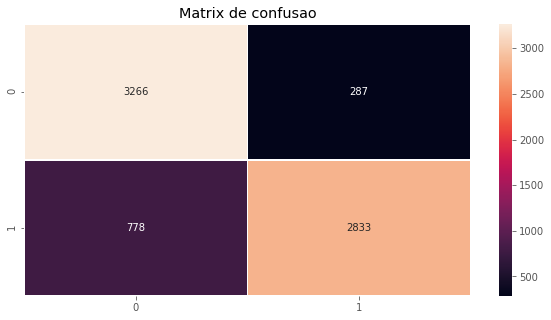

In [17]:
cm = confusion_matrix(y_test, y_predic)
#print(cm)

plt.style.use("ggplot")
plt.figure(figsize=(10,5))
plt.title('Matrix de confusao')
sns.heatmap(cm, annot=True, fmt="d", linewidth=0.5)
plt.show()

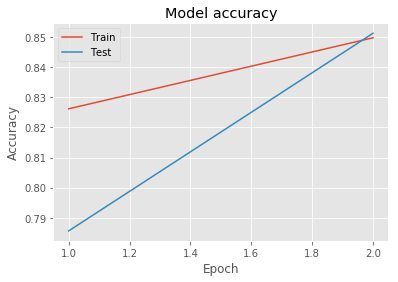

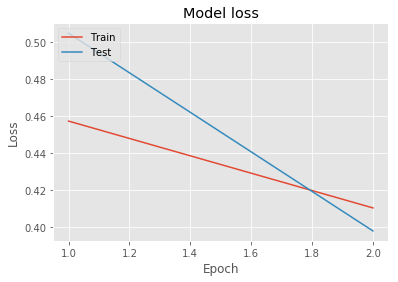

In [22]:
epochs = range(1, len(history.history['loss']) + 1)

plt.style.use("ggplot")
plt.figure()

# Plot training & validation accuracy values
plt.plot(epochs, history.history[ 'accuracy'])
plt.plot(epochs, history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [20]:
history.history

{'val_loss': [0.5045865931860699, 0.39800226910945624],
 'val_accuracy': [0.785594642162323, 0.8513400554656982],
 'loss': [0.4572213055201002, 0.4104091464447968],
 'accuracy': [0.826204, 0.84983546]}